# SacCer1 *in vivo* and *in vitro* nucleosome ChromWave

In this notebook we show how to load the pre-processed sacCer1 *in vitro* and *in vivo* MNase-seq data (Kaplan et al 2009) and trained ChromWave model. We compute in silico mutagenesis scores and saliency maps which we visualiss using the DNA sequence as in Figure 3D.

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import os
import numpy
import pandas
import sys
from chromwave import runtime_dataset, filesystem, chromwavenet, vis

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

## Setting up the directories

You'll need the data in the repository, please make sure you've cloned it and the working directoy points to it.

In [3]:
# working directory should be ChromWave/scripts/Tutorials_Workflows. if not change project dir to be the directory 
# containing the code for ChromWave
project_dir = os.path.abspath(os.path.join(os.getcwd(),'../../../'))
working_dir = os.path.join(project_dir, 'ChromWave')

output_dir = os.path.join(project_dir,'Test')

In [4]:
data_dir = os.path.join(working_dir, 'data')
model_dir = os.path.join(working_dir, 'models')

nuc_profile_inVivo = os.path.join(data_dir,'kaplan2009','Occupancy_inVivo_sacCer1.csv')
nuc_profile_inVitro = os.path.join(data_dir,'kaplan2009','Occupancy_inVitro_sacCer1.csv')


inVitro_nuc_model_dir = os.path.join(model_dir,'nucleosomes/sacCer1_inVitro')
inVivo_nuc_model_dir = os.path.join(model_dir,'nucleosomes/sacCer1_inVivo')

# Loading the data

We first set up the FileSystem, passing the location of the genome fa files, the output directory and nucleosome profiles of the in vitro profiles of the Kaplan et al 2009 data. If the output folder was already created we will overwrite as this instance. We have no test data to pass and we split the dataset into 20% test and 10% validation data (and 80% training data). 

We then load the data as a RuntimeDataset object with the underlying FileSystem. The sequences in the training, test and validation data will be shuffled but for testing purposes we use a fixed seed. We include the reverse complements of each sequence and remove sequences if a third of the region has a flat signal. The class weight cap denotes the max at which the class weights (computed as median/frequency per class) are capped to avoid extremely high weights for rarely occuring classes. 

In [5]:
f = filesystem.FileSystem(os.path.join(data_dir,'genomes/sacCer1'), os.path.join(output_dir,'kaplan2009'), source_profile=nuc_profile_inVitro, overwrite=True, resume=False)
r = runtime_dataset.RuntimeDataset(f)
r.data_format = 'processed_counts'

nuc_preprocessing_params = {'times_median_coverage_max': 3,  'u': 2.5, 
                            'smooth_signal': True, 'sigma': 5,
                            'truncate': 3, 'smoothing_function': 'gaussian_filter1d', 
                            'normalise_read_counts': None}

r.preprocessing_params = [nuc_preprocessing_params]
r.load_data()


Loading genomic data... 
Mitochondrial chromosome will be kept as separate data...
using pre-processing params:
{'times_median_coverage_max': 3, 'u': 2.5, 'smooth_signal': True, 'sigma': 5, 'truncate': 3, 'smoothing_function': 'gaussian_filter1d', 'normalise_read_counts': None}
I am assuming that the columns in the provided csv file are: seqname, start, score. If this is not the case, abort and change the input format!
Binding profiles were binned into [22] bins.


# Loading the models

We start by loading the in vivo and in vitro nucleosome models from the model directory

In [6]:
from importlib import reload
reload(chromwavenet)
in_vitro_nuc_model =  chromwavenet.ChromWaveNet()
in_vitro_nuc_model.deserialize(directory = inVitro_nuc_model_dir)

in_vivo_nuc_model =  chromwavenet.ChromWaveNet()
in_vivo_nuc_model.deserialize(directory = inVivo_nuc_model_dir)


Receptive Field: 2047 
Receptive Field: 2047 


In [7]:
in_vitro_nuc_model.preprocessing_params

[{'truncate': 3,
  'smooth_signal': True,
  'smoothing_function': 'gaussian_filter1d',
  'u': 2.5,
  'normalise_read_counts': None,
  'times_median_coverage_max': None,
  'sigma': 5}]

The following plots the model architecture to the model directory

In [8]:
in_vitro_nuc_model.plot_model(directory=inVitro_nuc_model_dir)
in_vivo_nuc_model.plot_model(directory=inVivo_nuc_model_dir)

# In silico Mutagenesis

We first select the region of interest (e.g. TSS in see Figure 3D) and extract the genomic sequence

In [9]:
prom_chr= 'chr10'
prom_start=365479 -1000
prom_end =365479 +1000
x=r.genome_data[r.chr_info.index(prom_chr)][:,prom_start:prom_end]
x=numpy.expand_dims(numpy.swapaxes(x,0,1),0)

We then use the functions of the ChromWave models to compute the in silico mutagenesis scores:

In [10]:
x_mut = in_vitro_nuc_model.in_silico_mutagenesis(x,r)[0]
#
x_mut_vivo = in_vivo_nuc_model.in_silico_mutagenesis(x,r)[0]

ISM: sample:0
Smoothing predictions before taking the difference using preprocessing parameters of supplied runtime_dataset instance.
ISM: sample:0
Smoothing predictions before taking the difference using preprocessing parameters of supplied runtime_dataset instance.


In [11]:
x_mut[0].shape

(1, 2000, 2000, 4)

The function returns a list of arrays: the difference in predictions between base change and WT, the predictions for each base change, the preactivations for each base change, and the difference of preactivations for each base change and WT. For sample 0, first base, the predictions of all possible basechanges are in:

In [12]:
x_mut[0][0,0,:,:]

array([[-0.04366991,  0.        ,  0.31700454, -0.18836997],
       [-0.06034448,  0.        ,  0.33084263, -0.1969302 ],
       [-0.09288922,  0.        ,  0.3534242 , -0.2123352 ],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [13]:
predictions_mut = x_mut[0]
predictions_mut_vivo = x_mut_vivo[0]

The ISM scores for a specific segment of the sequence is then computed as sum along axis 2 within the range we are interested in. The output array is of shape `[1,len_seq,num_bases]` and can be visualised as a heatmap downstream. For Figure 3D, this is the following region: 

In [14]:
min=631
max=882
# sum of delta within region min:max achievable by each base mutation
sumdelta_per_base_mut = numpy.sum(predictions_mut[:,:,min:max,:],2)

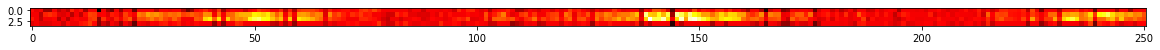

In [15]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(numpy.squeeze(sumdelta_per_base_mut,0)[min:max,:].transpose(), cmap='hot')
plt.show()

To find the maximal gain and losses in the profile at each position given all possible base changes along the sequence to identify dynamic nucleosome binding 'hotspots' we can do:

In [16]:
# max achievable changes mutating the each base
maxdelta_profile=numpy.max(numpy.max(predictions_mut,axis=1),-1)
# min achievable changes mutating the each base
mindelta_profile=numpy.min(numpy.min(predictions_mut,axis=1),-1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f16c4568310>,
      dtype=object)

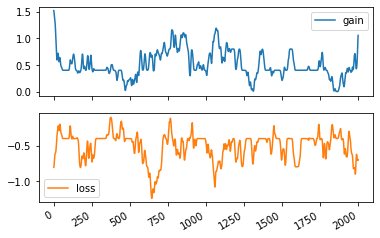

In [17]:
pandas.DataFrame(numpy.vstack([maxdelta_profile,mindelta_profile]).transpose(), columns=['gain','loss']).plot(subplots=True)

# Saliency maps

ChromWave models can compute the saliency maps for each output profile for certain positions (or ranges). Note that the function `compute_saliency` returns a list of arrays, so to save with numpy use `numpy.savez` as indicated below. 

In [18]:
saliceny_scores_for_seq = in_vitro_nuc_model.compute_saliency(sequence_data = x,min=631,max=1119)
# 
#numpy.savez( os.path.join(directory,Promoter_name+'scores.npz'), *scores_for_seq)

In case of the nucleosome models we only have one output profile for which we can plot the saliency scores: 

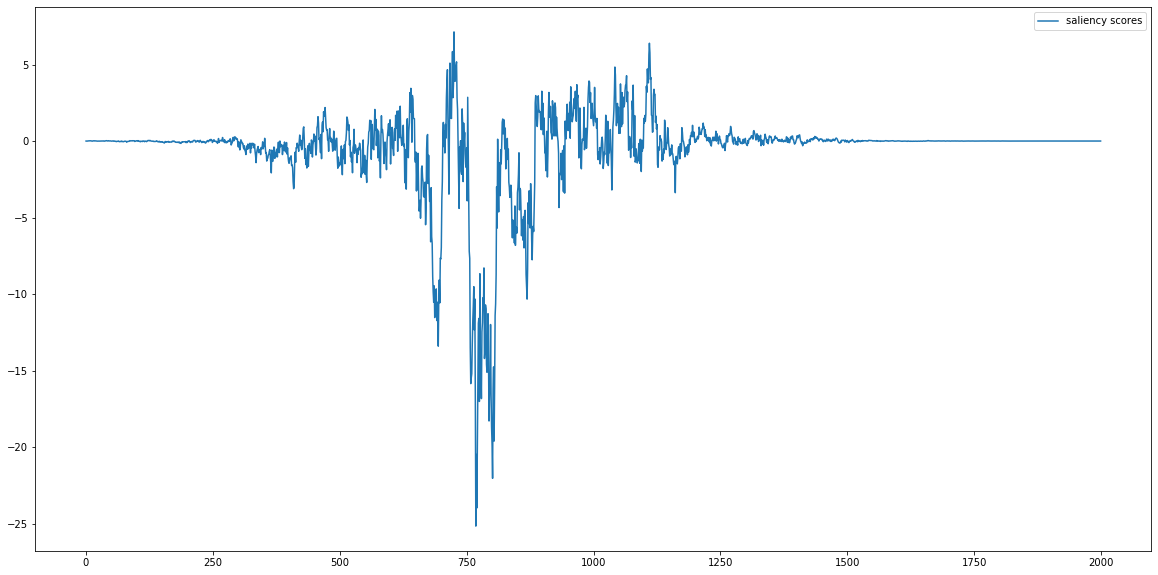

In [19]:

pandas.DataFrame(numpy.squeeze(numpy.sum(saliceny_scores_for_seq[0],-1),0).transpose(),columns=['saliency scores']).plot(figsize=(20,10))

And we can also plot the underlying sequence scaled by the saliency scores:

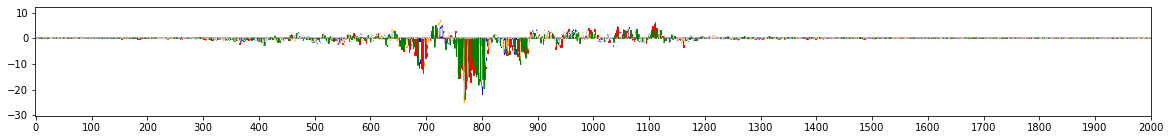

In [20]:
from chromwave.vis import plot, viz_sequence
viz_sequence.plot_weights(numpy.squeeze(saliceny_scores_for_seq[0],0), subticks_frequency=100)

It's a little difficult to see what is going on, let's zoom in a little to the area of interest. 

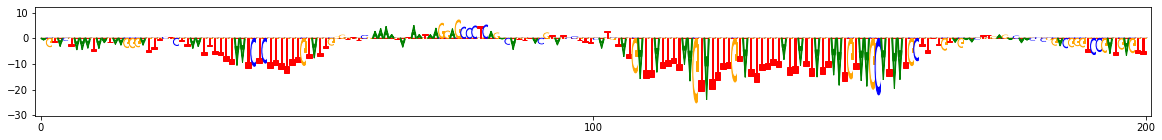

In [21]:
viz_sequence.plot_weights(saliceny_scores_for_seq[0][:, 650:850, :], subticks_frequency=100)